In [2]:
import numpy as np 
import pandas as pd 
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

In [3]:
df = pd.read_csv('../input/tehran-stock-price/output.csv').rename(columns={'Unnamed: 0':'timestamp'}).set_index('date')
df=df[["close","open"]]

In [4]:
test_set_size = int(np.round(0.2*df.shape[0]));
train_set_size = df.shape[0] - (test_set_size); 
train_set =df[:train_set_size]
valid_set = df[train_set_size:]
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(df)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(df)))

Proportion of train_set : 0.80%
Proportion of valid_set : 0.20%


In [5]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)
n_steps = 2
train_x,train_y = split_sequence(train_set["close"],n_steps)
valid_x,valid_y = split_sequence(valid_set["close"],n_steps)

### Build CNN Forecast Model

In [59]:
class StockDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [62]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(2,128,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = x.view(-1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [64]:
print(model)

CNN_ForecastNet(
  (conv1d): Conv1d(2, 128, kernel_size=(1,), stride=(1,))
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=128, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


#### Do I have to think autocorrelation when setting batch_size? 
Maybe Batch_size is important, and It is related with autocorrelation I guess.

In [72]:
train = StockDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid =  StockDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [75]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss**(0.5)
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss**(0.5)
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [77]:
epochs = 20
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/20
train_loss 188.8728485107422
valid_loss 184.86624145507812
epochs 2/20
train_loss 188.8064727783203
valid_loss 184.2938232421875
epochs 3/20
train_loss 188.2359619140625
valid_loss 183.78916931152344
epochs 4/20
train_loss 187.732177734375
valid_loss 183.2985076904297
epochs 5/20
train_loss 187.268798828125
valid_loss 182.82408142089844
epochs 6/20
train_loss 186.78408813476562
valid_loss 182.35791015625
epochs 7/20
train_loss 186.34613037109375
valid_loss 181.8966827392578
epochs 8/20
train_loss 185.90756225585938
valid_loss 181.44407653808594
epochs 9/20
train_loss 185.46580505371094
valid_loss 181.00173950195312
epochs 10/20
train_loss 185.05825805664062
valid_loss 180.57640075683594
epochs 11/20
train_loss 184.63479614257812
valid_loss 180.16436767578125
epochs 12/20
train_loss 184.2467498779297
valid_loss 179.75796508789062
epochs 13/20
train_loss 183.83807373046875
valid_loss 179.36192321777344
epochs 14/20
train_loss 183.4651336669922
valid_loss 178.9736785888672
epo

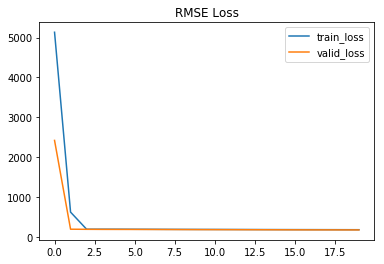

In [39]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('RMSE Loss')
plt.legend()

In [40]:
target_x , target_y = split_sequence(valid_set["close"],n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

In [50]:
target_x.shape

(668, 2)

In [41]:
model.eval()
prediction = []
batch_size = 1
iterations =  inputs.shape[0]

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds.detach().numpy())

#### Prediction Result

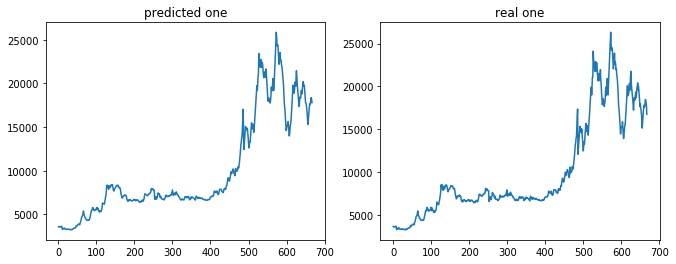

In [42]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()

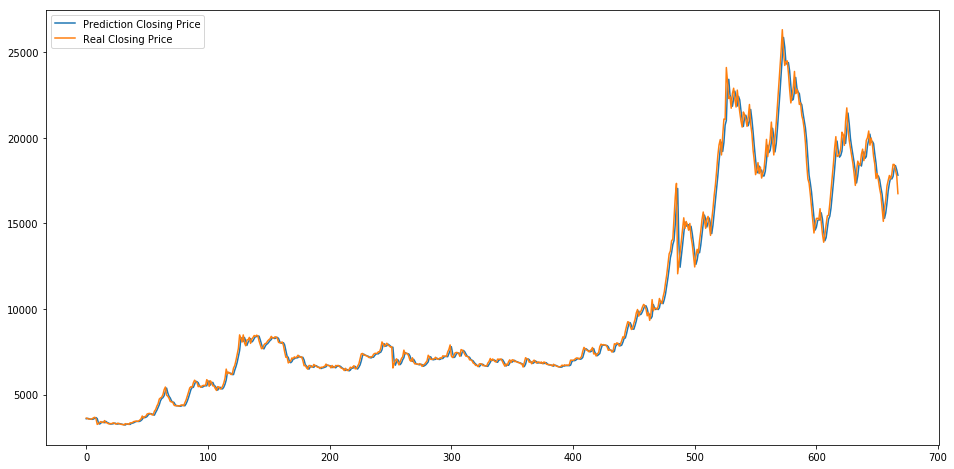

In [43]:
plt.figure(figsize=(16,8))
plt.plot(prediction,label='Prediction Closing Price')
plt.plot(target_y,label='Real Closing Price')
plt.legend()